<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

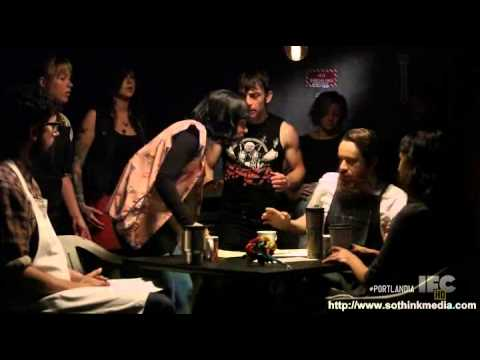

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/home/scrunts23/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head(3)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating


In [5]:
# simple data wrangling 
shops['date'] = shops['full_review_text'].apply(lambda x: x.split()[0])
shops['date'].head(3)

0    11/25/2016
1     12/2/2016
2    11/30/2016
Name: date, dtype: object

In [3]:
# removing dates from ['full_review_text']
shops['review'] = shops['full_review_text'].apply(lambda x: " ".join(x.split()[1:]))
shops['review'].head(3)

0    1 check-in Love love loved the atmosphere! Eve...
1    Listed in Date Night: Austin, Ambiance in Aust...
2    1 check-in Listed in Brunch Spots I loved the ...
Name: review, dtype: object

In [18]:
shops['review'] = shops['review'].apply(lambda x: x.lower())

In [19]:
shops.head(3)

,coffee_shop_name,full_review_text,star_rating,not_needed,review,date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,11/25/2016,1 check-in love love loved the atmosphere! eve...,11/25/2016
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,12/2/2016,"listed in date night: austin, ambiance in aust...",12/2/2016
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,11/30/2016,1 check-in listed in brunch spots i loved the ...,11/30/2016


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [20]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [26]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Tokenizer Pipe
tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['review'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [27]:
shops['tokens'].head(3)

0    [1, check-in, love, love, loved, the, atmosphe...
1    [listed, in, date, night:, austin,, ambiance, ...
2    [1, check-in, listed, in, brunch, spots, i, lo...
Name: tokens, dtype: object

In [33]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [35]:
wc = count(shops['tokens'])

In [36]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
67,the,6847,34649,1.0,0.044535,0.044535,0.899028
30,and,6853,26442,2.0,0.033986,0.078521,0.899816
6,a,6240,22657,3.0,0.029121,0.107642,0.819328
50,i,5511,19990,4.0,0.025693,0.133336,0.723608
41,to,5638,17008,5.0,0.021861,0.155197,0.740284


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


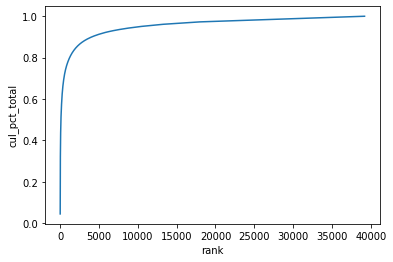

In [37]:
# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [38]:
wc[wc['rank'] <= 100]['cul_pct_total'].max()

0.505128402868821

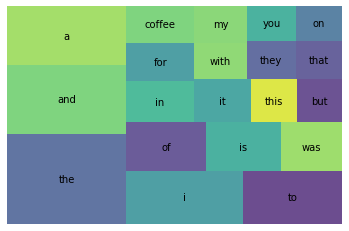

In [40]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Now to use stop words to get rid of the common words 

In [44]:
tokens = []

""" Update those tokens w/ stopwords"""
for doc in tokenizer.pipe(shops['review'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [45]:
shops.tokens.head()

0    [1, check-in, love, love, loved, atmosphere!, ...
1    [listed, date, night:, austin,, ambiance, aust...
2    [1, check-in, listed, brunch, spots, loved, ec...
3    [cool, decor!, good, drinks, nice, seating, ho...
4    [1, check-in, located, northcross, mall, shopp...
Name: tokens, dtype: object

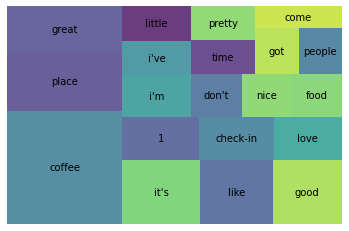

In [47]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

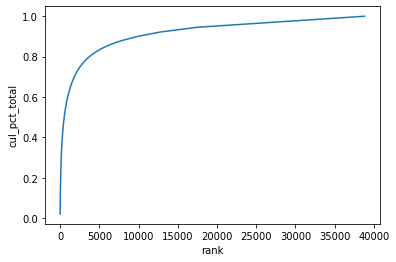

In [48]:
# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

## Extend Stop words

In [65]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ','coffee','1', 'got', 'place', 'time', 'check-in', "it's", "i've", "i'm",
                                            "don't", "coffee.", "-", "shop", "austin"])

In [66]:
tokens = []

for doc in tokenizer.pipe(shops['review'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [67]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
120,great,2438,3250,1.0,0.008962,0.008962,0.320116
158,like,2034,2902,2.0,0.008003,0.016965,0.267069
164,good,2084,2779,3.0,0.007663,0.024628,0.273634
7,love,1434,1806,4.0,0.004980,0.029608,0.188288
780,little,1230,1479,5.0,0.004078,0.033687,0.161502


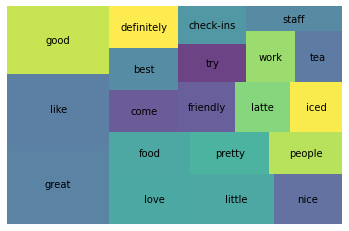

In [68]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

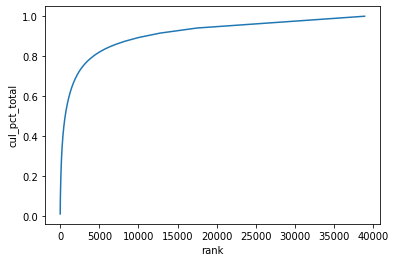

In [69]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

